In [ ]:
%pip install python-dotenv
%pip install roboflow
%pip install supervision
!pip install imagehash pillow

In [ ]:
# loads dataset
from roboflow import Roboflow
from dotenv import load_dotenv
from google.colab import userdata
import os

load_dotenv()  # loads variables from .env into the environment

os.environ["YF_API_KEY"] = userdata.get("YF_API_KEY")
api_key = os.getenv("YF_API_KEY")

rf = Roboflow(api_key=api_key)
project = rf.workspace("caretech").project("food-dataset-uj20h-w2s4m")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
print(type(os.getenv("YF_API_KEY")))

In [12]:
# script to split training dataset
import os
import shutil
from pathlib import Path
import supervision as sv


# creates a new folder with just the images and labels
dir = Path('/content/Food-Dataset-1')
unified_dir = Path('/content/all')
split_path = Path('/content/split')

new_img_dir = unified_dir / 'images'
new_label_dir = unified_dir / 'labels'

new_img_dir.mkdir(parents=True, exist_ok=True)
new_label_dir.mkdir(parents=True, exist_ok=True)

# write to a flattened folder
for file in dir.rglob('*.jpg'):
    shutil.copy(file, new_img_dir)

exclude = ['README.roboflow.txt', 'README.dataset.txt']
for file in dir.rglob('*.txt'):
    if str(file.name) in exclude:
        continue
    shutil.copy(file, new_label_dir)


In [14]:
# this loads a DetectionDataset object
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{str(new_img_dir)}",
    annotations_directory_path=f"{str(new_label_dir.name)}",
    data_yaml_path=f"{str(dir.name)}/data.yaml"
)

print(ds.classes)

seed = 1
# we can split this dataset deterministically
train_ds, rest_ds = ds.split(split_ratio=0.8, random_state=seed, shuffle=True)
test_ds, val_ds = rest_ds.split(split_ratio=0.5, random_state=seed, shuffle=True)

# save new datasets in yolo format
train_ds.as_yolo(
    images_directory_path=str(split_path / 'train' / 'images'),
    annotations_directory_path=str(split_path / 'train' / 'labels'),
    data_yaml_path=str(split_path / 'train' / 'data.yaml')
)
test_ds.as_yolo(
    images_directory_path=str(split_path / 'test' / 'images'),
    annotations_directory_path=str(split_path / 'test' / 'labels'),
    data_yaml_path=str(split_path / 'test' / 'data.yaml')
)
val_ds.as_yolo(
    images_directory_path=str(split_path / 'valid' / 'images'),
    annotations_directory_path=str(split_path / 'valid' / 'labels'),
    data_yaml_path=str(split_path / 'valid' / 'data.yaml')
)

# write the manifest files
def write_manifest(ds: sv.DetectionDataset, split: str, output_path: Path):
  with open(output_path, "w") as f:
    for img_path, _, _ in ds:
      f.write(f"{str(Path(img_path).name)}\n")

  print(f"Wrote to {output_path}")

write_manifest(train_ds, "train", Path(split_path) / "train.txt")
write_manifest(test_ds, "test", Path(split_path) / "test.txt")
write_manifest(val_ds, "valid", Path(split_path) / "valid.txt")

['Apple', 'Japanese-style-pancake', 'Orange', 'beef-curry', 'beef-noodle', 'bibimbap', 'chicken-n-egg-on-rice', 'chicken-rice', 'chip-butty', 'croissant', 'eels-on-rice', 'fried-noodle', 'fried-rice', 'gratin', 'hamburger', 'pilaf', 'pizza', 'pork-cutlet-on-rice', 'raisin-bread', 'ramen-noodle', 'rice', 'roll-bread', 'sandwiches', 'soba-noodle', 'spaghetti', 'sushi', 'takoyaki', 'tempura-bowl', 'tempura-udon', 'tensin-noodle', 'toast', 'udon-noodle']
Wrote to /content/split/train.txt
Wrote to /content/split/test.txt
Wrote to /content/split/valid.txt


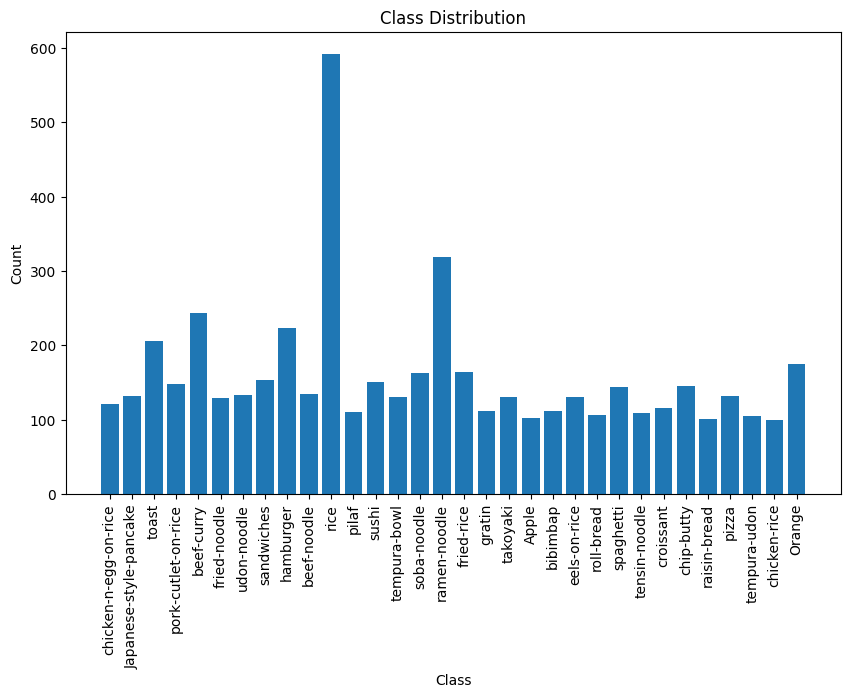

<Figure size 1000x600 with 0 Axes>

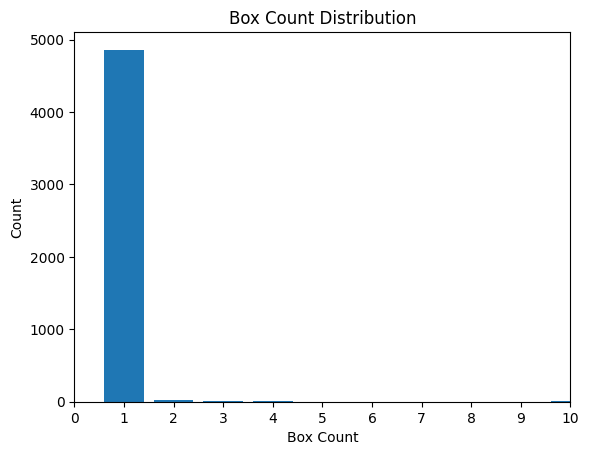

In [15]:
# class distribution count
# box count distribution
# image size
# aspect ratio
# missing/invalid boxes
# show 12 images with bounding boxes
# boxes outside image bounds
# duplicates

# class distribution count
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

class_labels = { i: ds.classes[i] for i in range(len(ds.classes)) }

class_count = defaultdict(int)
box_count = defaultdict(int)
for file in unified_dir.rglob('*.txt'):
    count = 0
    with open(file, 'r') as f:
        for line in f:
          arr = line.split()
          if not arr:
            continue

          i = int(arr[0])
          class_count[class_labels[i]] += 1
          count += 1

    box_count[count] += 1

# class distribution plot
plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

# box count plot
plt.figure(figsize=(10, 6))
ax = plt.figure().gca()
plt.bar(box_count.keys(), box_count.values())
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 10])
plt.xlabel('Box Count')
plt.ylabel('Count')
plt.title('Box Count Distribution')
plt.show()

# heavy class imbalance towards rice, and somewhat towards ramen noodles
# also data imbalance towards having only 1 bounding box, even when there are multiple food items

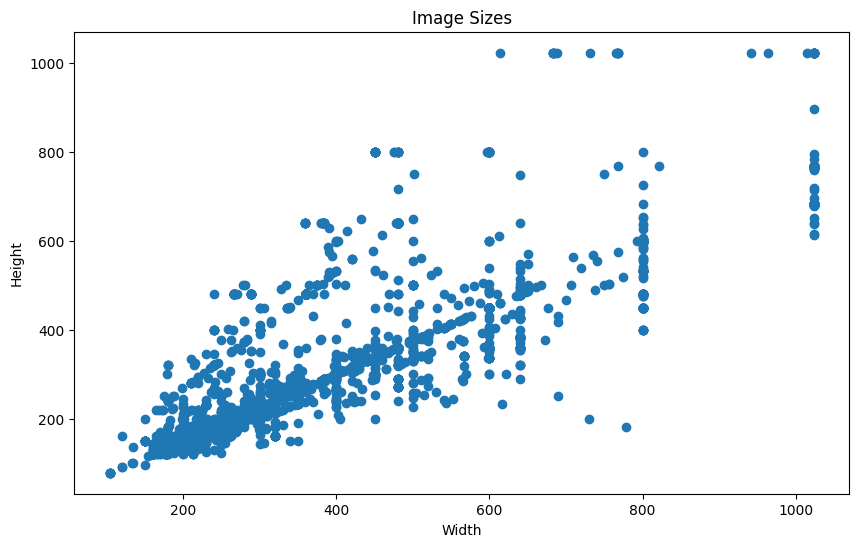

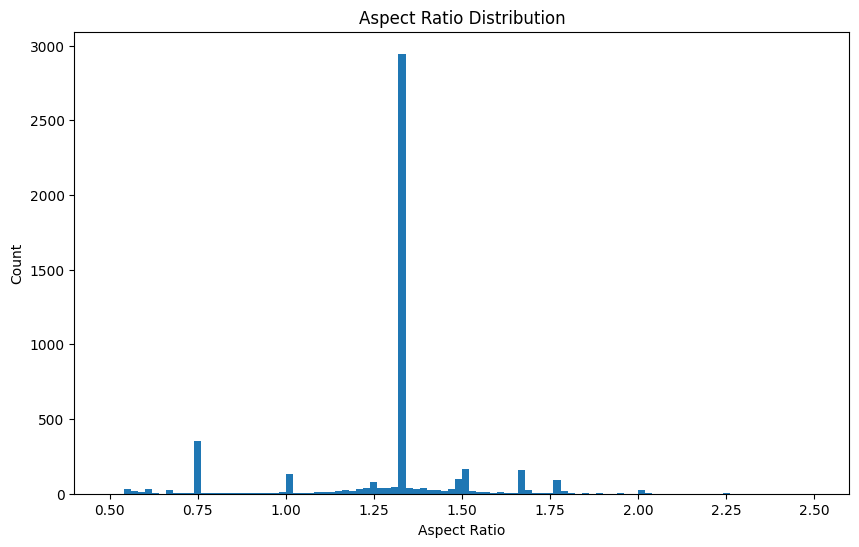

In [16]:
from PIL import Image

# image size
sizes: list[tuple[int, int]] = [] # width x height
for img in unified_dir.rglob('*.jpg'):
  with Image.open(img) as im:
    sizes.append(im.size)

ratios = [s[0] / s[1] for s in sizes]

# image size plot
plt.figure(figsize=(10, 6))
plt.scatter([s[0] for s in sizes], [s[1] for s in sizes])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Sizes')
plt.show()

# aspect ratio distribution plot
plt.figure(figsize=(10, 6))
plt.hist(ratios, bins=100, range=(0.5, 2.5))
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.title('Aspect Ratio Distribution')
plt.show()

# images have a consistent aspect ratio -- good

In [19]:
# Images with missing boxes

missing_boxes = []
total_images = 0

for img in unified_dir.rglob("*.jpg"):
    total_images += 1
    label_path = img.parent.parent / "labels" / f"{img.stem}.txt"

    if not label_path.exists(): # missing label file
        missing_boxes.append(img)
    elif label_path.read_text().strip() == "": # empty label file
        missing_boxes.append(img)

print("=== Missing boxes summary ===")
print(f"Total images: {total_images}")
print(f"Images with missing boxes: {len(missing_boxes)}")

# no missing boxes -- good

=== Missing boxes summary ===
Total images: 4910
Images with missing boxes: 0


Total images found: 4910


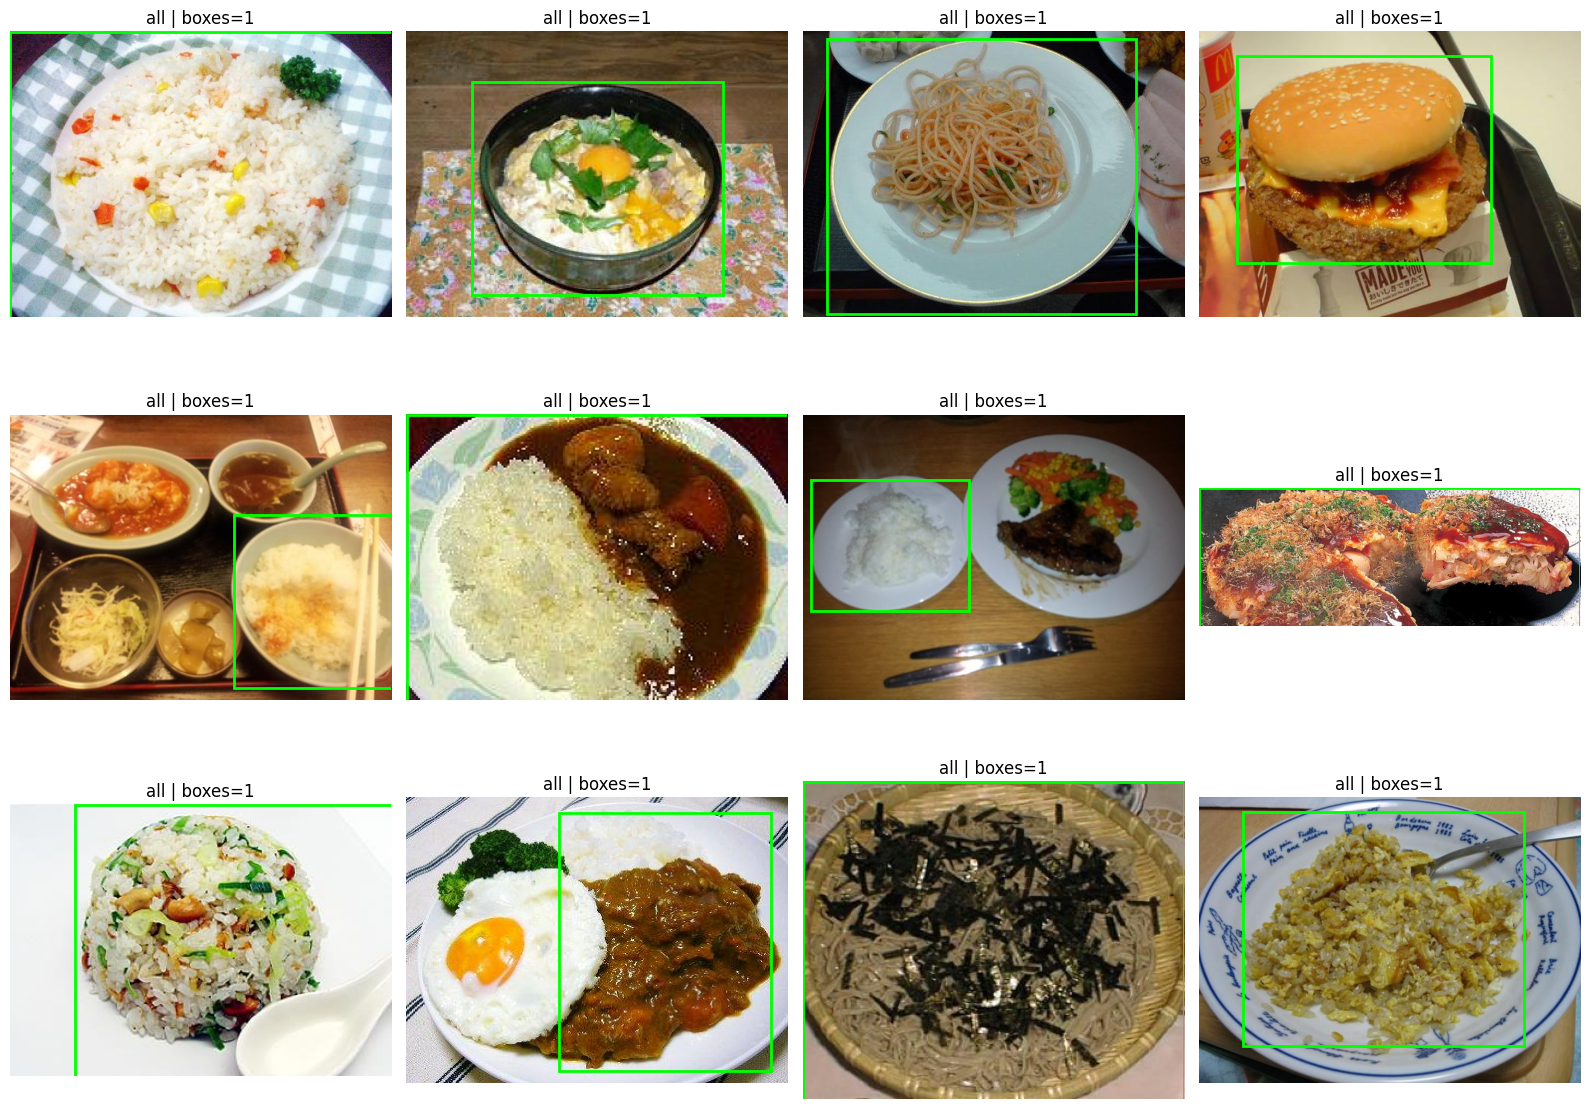

In [22]:
# Plot 12 random images with bounding boxes to potentially spot label issues

import random
import matplotlib.patches as patches

# Randomly sample 12 images
image_paths = []
for img in unified_dir.rglob('*.jpg'):
  image_paths.append(img)
sample_imgs = random.sample(image_paths, 12)

# Plot the 12 images
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()
for ax, img_path in zip(axes, sample_imgs):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    ax.imshow(img)
    ax.axis("off")

    # Corresponding label path
    label_path = img_path.parent.parent / "labels" / f"{img_path.stem}.txt"
    if not label_path.exists():
        ax.set_title("NO LABEL", color="red")
        continue
    lines = label_path.read_text().strip().splitlines()
    ax.set_title(f"{img_path.parent.parent.name} | boxes={len(lines)}")

    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            continue
        cls, xc, yc, bw, bh = map(float, parts)

        # YOLO normalized -> pixel coords
        x1 = (xc - bw / 2) * w
        y1 = (yc - bh / 2) * h
        box_w = bw * w
        box_h = bh * h

        rect = patches.Rectangle(
            (x1, y1),
            box_w,
            box_h,
            linewidth=2,
            edgecolor="lime",
            facecolor="none"
        )
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

# seemingly no labeling issues -- good

In [24]:
# Boxes outside image bounds

images_with_oob_boxes = []
total_images = 0
total_oob_boxes = 0

for img in unified_dir.rglob('*.jpg'):
    total_images += 1
    label_path = img.parent.parent / "labels" / f"{img.stem}.txt"
    if not label_path.exists():
        continue

    has_oob = False
    for line in label_path.read_text().splitlines():
        parts = line.split()
        if len(parts) != 5:
            continue
        _, xc, yc, w, h = map(float, parts)
        x1 = xc - w / 2
        y1 = yc - h / 2
        x2 = xc + w / 2
        y2 = yc + h / 2
        if x1 < 0 or y1 < 0 or x2 > 1 or y2 > 1:
            has_oob = True
            total_oob_boxes += 1
            break  # count image once

    if has_oob:
        images_with_oob_boxes.append(img)

print("=== Out-of-bounds boxes summary ===")
print(f"Total images checked: {total_images}")
print(f"Images with ≥1 out-of-bounds box: {len(images_with_oob_boxes)}")
print(f"Total out-of-bounds boxes (min): {total_oob_boxes}")

# no out of bounds boxes -- good

=== Out-of-bounds boxes summary ===
Total images checked: 4910
Images with ≥1 out-of-bounds box: 0
Total out-of-bounds boxes (min): 0


Near-duplicate pairs found: 159
Examples:


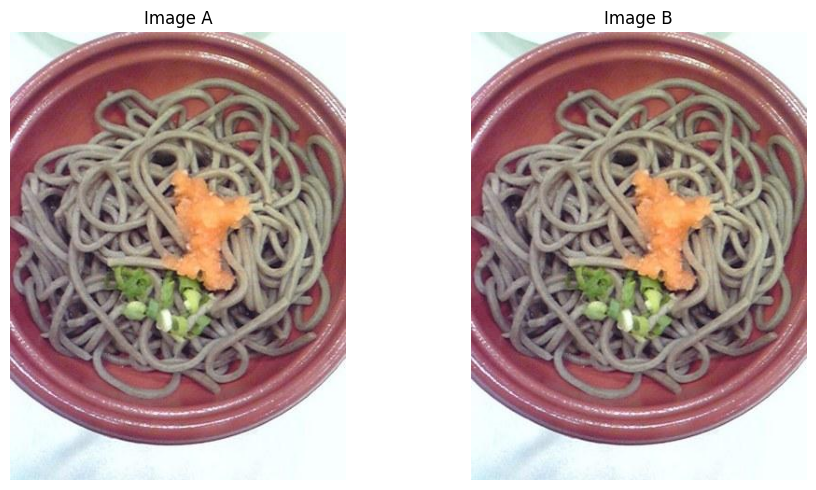

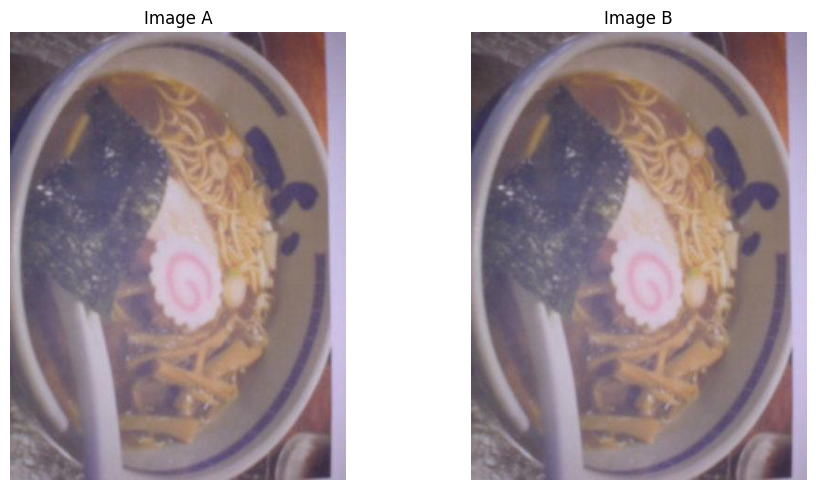

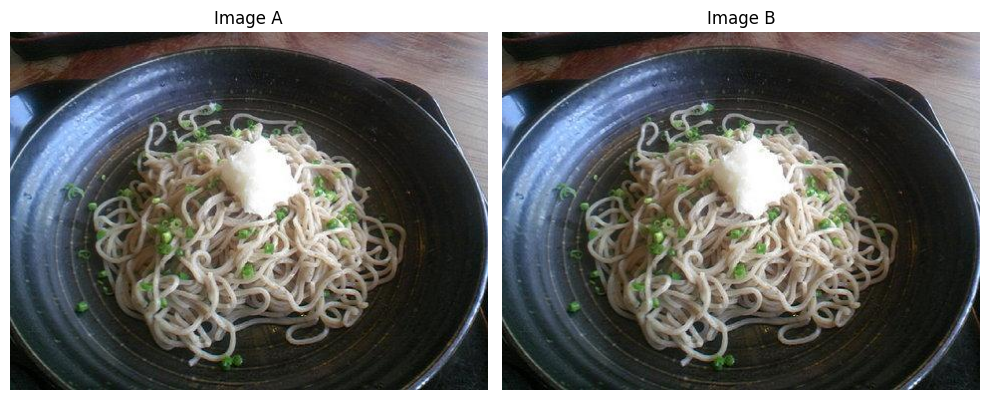

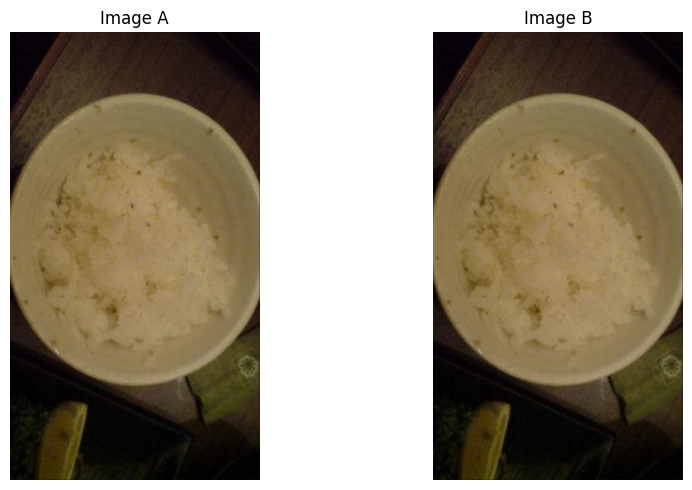

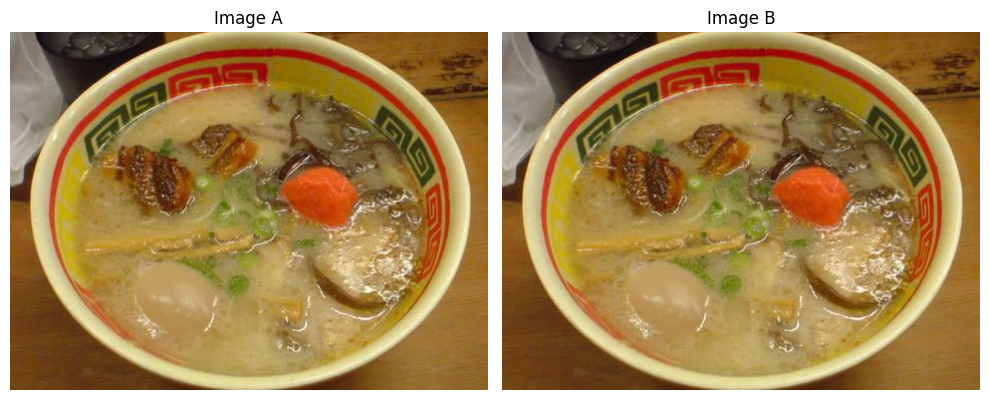

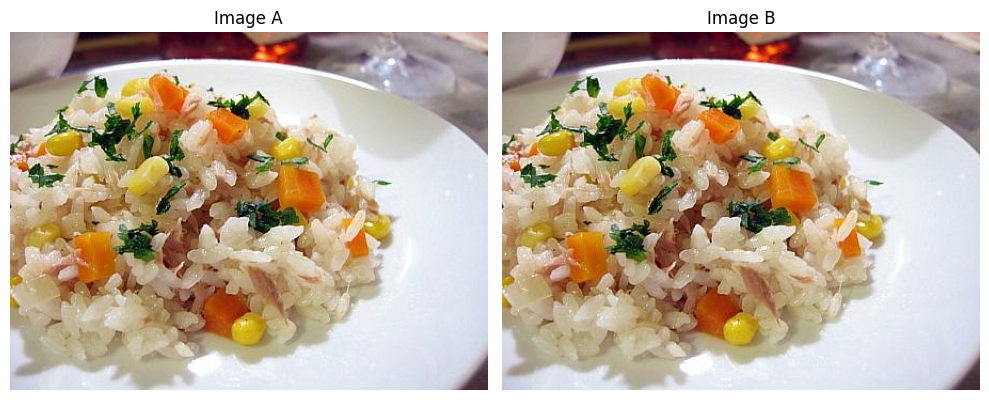

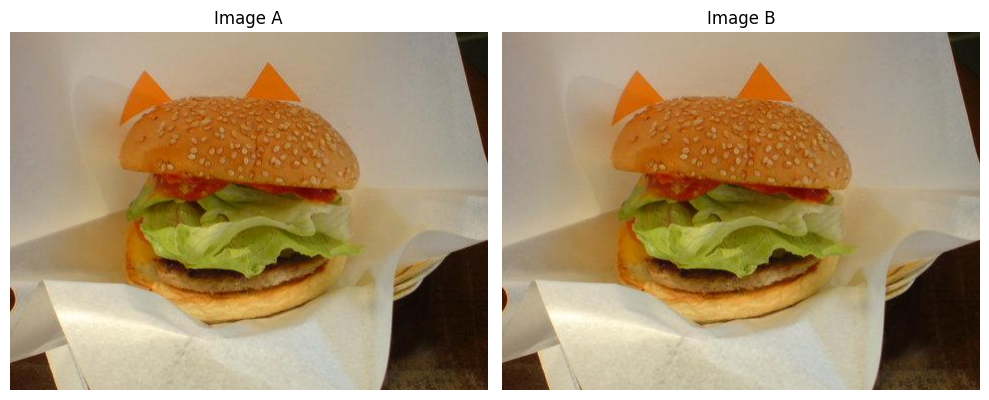

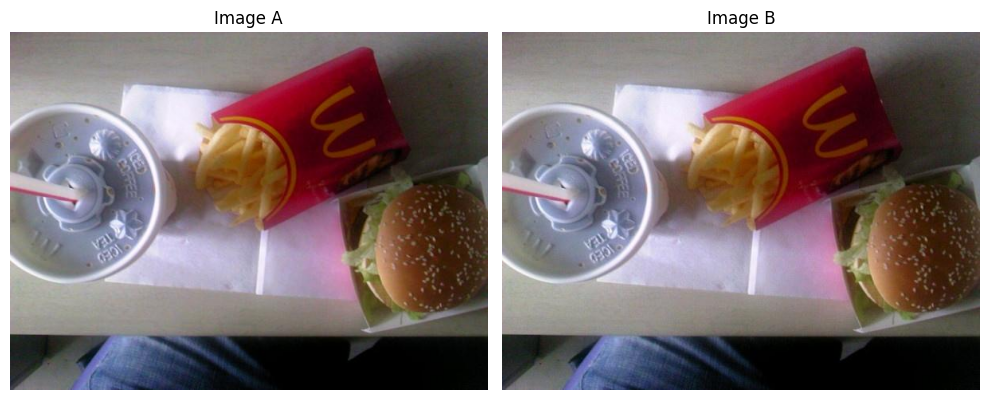

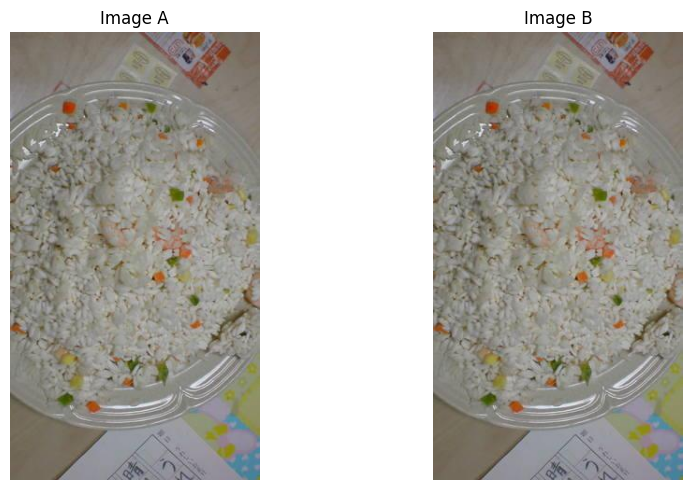

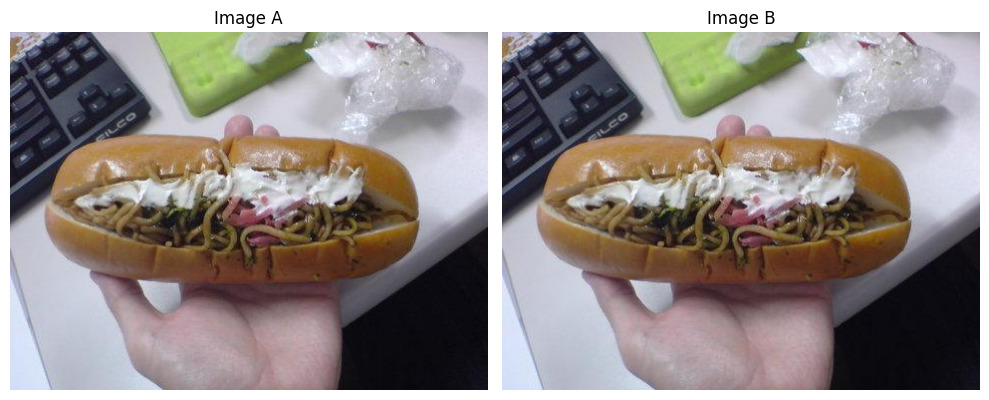

In [31]:
# Check for duplicate images

import imagehash

hashes = {}
duplicates = []
for img in unified_dir.rglob('*.jpg'):
    h = imagehash.phash(Image.open(img).convert("RGB"))
    if h in hashes:
        duplicates.append((img, hashes[h]))
    else:
        hashes[h] = img

def show_image_pair(img1, img2, title1="Image A", title2="Image B"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(Image.open(img1))
    axes[0].set_title(title1)
    axes[0].axis("off")

    axes[1].imshow(Image.open(img2))
    axes[1].set_title(title2)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

print("Near-duplicate pairs found:", len(duplicates))
print("Examples:")
for a, b in duplicates[:10]:
    show_image_pair(a,b)

# only ~4% duplicates -- not bad

In [36]:
# Check for cross-split duplicates

def get_split(img_path) -> str:
    p = Path(img_path)
    # .../<split>/images/<file>
    return p.parent.parent.name

cross_split = []

for item in duplicates:
    a, b = item[0], item[1]
    sa, sb = get_split(a), get_split(b)
    if sa != sb:
        cross_split.append((a, b, sa, sb))

print("Duplicate pairs:", len(duplicates))
print("Cross-split duplicate pairs:", len(cross_split))

for row in cross_split[:10]:
    print(row)

# no cross-split duplicates --> no data leakage -- good

Duplicate pairs: 159
Cross-split duplicate pairs: 0
